# CHARIS MCMC with Unpolarized Standard

In [1]:
import multiprocessing as mp
import os
mp.set_start_method("spawn", force=True) # Jax was slowing down from os.fork() and this fixed it
os.environ["JAX_PLATFORM_NAME"] = "cpu" # Jax wasn't working with our GPU for unknown reasons
import sys
import numpy as np
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
import re
import instruments as inst
from instruments_jax import *
from pyMuellerMat.physical_models.charis_physical_models import *
from scipy import stats as scipy_stats
import h5py
import corner
import shutil
import tqdm
from csv_tools import read_csv_physical_model_all_bins

To make the csv, I used the CSV writer in `on_sky.py`, `write_fits_info_to_csv_psf()`. It's similar to the internal cal one, but it has some inputs for aperture stuff all detailed in the docstring. The csv reader here reads in all bins, and can configuration lists be toggled for on sky data by setting `m3=True`.

In [2]:
# Use on sky mode for read function

csv_dir = Path('datacsvs/onsky_csvs/unpol_standards')
interleaved_values_all, interleaved_stds_all, configuration_list_all = read_csv_physical_model_all_bins(csv_dir,m3=True)


In [3]:
print(configuration_list_all)

[{'hwp': {'theta': 0.0, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 97.8916, 'wavelength': 1159.5614}, 'altitude_rot': {'pa': 66.77899114}, 'M3': {'wavelength': 1159.5614}, 'parang_rot': {'pa': 126.5757623688055}, 'wollaston': {'wavelength': 1159.5614}}, {'hwp': {'theta': 45.0, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 97.80772, 'wavelength': 1159.5614}, 'altitude_rot': {'pa': 66.60077713}, 'M3': {'wavelength': 1159.5614}, 'parang_rot': {'pa': 126.1145151377112}, 'wollaston': {'wavelength': 1159.5614}}, {'hwp': {'theta': 22.5, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 97.70938, 'wavelength': 1159.5614}, 'altitude_rot': {'pa': 66.4212248}, 'M3': {'wavelength': 1159.5614}, 'parang_rot': {'pa': 125.6585613281019}, 'wollaston': {'wavelength': 1159.5614}}, {'hwp': {'theta': 67.5, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 97.61756, 'wavelength': 1159.5614}, 'altitude_rot': {'pa': 66.24067105}, 'M3': {'wavelength': 1159.5614}, 'parang_rot': {'pa': 125

In [3]:
# Getting the system dictionary setup and defining starting guesses values
from pyMuellerMat.common_mm_functions import SUBARU_M3_function
from pyMuellerMat.physical_models.charis_physical_models import M3_retardance,M3_diattenuation
from pyPolCal.constants import wavelength_bins
wavelength_bin = 15 # placeholder
offset_imr = -0.13959
offset_hwp = -1.59338
offset_cal = -0.11835
imr_theta = 0 # placeholder 
hwp_theta = 0 # placeholder
# Past fits from scipy minimize on the naive fits
wsio2 = 1.63398
wmgf2 = 1.27711
hwp_phi = HWP_retardance(wavelength_bins,wsio2,wmgf2)[wavelength_bin]
m3_diat = M3_diattenuation(wavelength_bins[4])
m3_ret = M3_retardance(wavelength_bins[4])
m1=2.104
b1=14.2
m2=2.1
b2=13.2

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "CHARIS_wollaston_function",
            "properties" : {"wavelength": wavelength_bins[wavelength_bin], "beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "elliptical_IMR_function",
                "properties" : {"wavelength":wavelength_bins[wavelength_bin]},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "two_layer_HWP_function",
                "properties" : {"wavelength": wavelength_bins[wavelength_bin], "w_SiO2": wsio2, "w_MgF2": wmgf2, "theta":hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "altitude_rot" : {
                "type" : "rotator_function",
                "properties" : {"pa":77},
                "tag":"internal",
            },
            "M3" : {
                "type" : "SUBARU_M3_function",
                "properties" : {'wavelength': wavelength_bins[wavelength_bin], "m1" : 0,"b1":0,"m2":0,"b2":0},
                "tag": "internal",
            },
            "parang_rot" : {
                "type" : "rotator_function",
                "properties" : {"pa":39},
                "tag":"internal",
            },
            }
    }
    
# Starting guesses

p0_dict = {
    "M3" : 
        {"m1":m1,"b1":b1, "m2":m2,"b2":b2}
}

system_mm = inst.generate_system_mueller_matrix(system_dict) # Generating pyMuellerMat system MM

p0 = [1.623, 1.268, 262.56] # Starting guesses from Joost t Hart 2021 
offset_bounds = (-5.0,5.0) # Wider bounds than first MCMC run, offsets were converging to their bounds at first
d_bounds = (0.8*p0[2], 1.2*p0[2]) # Physical parameters shouldn't have changed much
imr_offset_bounds = offset_bounds
wsio2_bounds = (0.8*p0[0], 1.2*p0[0])
wmgf2_bounds = (0.8*p0[1], 1.2*p0[1])
hwp_offset_bounds = offset_bounds
cal_offset_bounds = offset_bounds
m1_bounds = (0.8*m1, 1.2*m1)
b1_bounds = (0.8*b1, 1.2*b1)
m2_bounds = (0.8*m2, 1.2*m2)
b2_bounds = (0.8*b2, 1.2*b2)
bounds = {
    "M3" : 
        {"m1": m1_bounds, "b1": b1_bounds, "m2": m2_bounds, "b2": b2_bounds},
}

# Defining uniform priors

# offset_prior = partial(mcmc.uniform_prior, low=-5.0, high=5.0)
# d_prior = partial(mcmc.uniform_prior, low=0.7*p0[2], high=1.3 * p0[2])
# imr_offset_prior = offset_prior
# wsio2_prior = partial(mcmc.uniform_prior, low=0.7*p0[0], high=1.3 * p0[0])
# wmgf2_prior = partial(mcmc.uniform_prior, low=0.7*p0[1], high=1.3 * p0[1])
# hwp_offset_prior = offset_prior
# cal_offset_prior = offset_prior


prior_dict = {
    "M3": {
        "m1": {"type": "uniform", "kwargs": {"low":0.8*m1, "high": 1.2 * m1}},
        "b1": {"type": "uniform", "kwargs": {"low":0.8*b1, "high": 1.2 * b1}},
        "m2": {"type": "uniform", "kwargs": {"low":0.8*m2, "high": 1.2 * m2}},
        "b2": {"type": "uniform", "kwargs": {"low":0.8*b2, "high": 1.2 * b2}},
    },
}


output_h5 = Path('mcmc_output_M3_elliptical_IMR.h5')

  0%|          | 100/40000 [05:20<36:02:54,  3.25s/it]

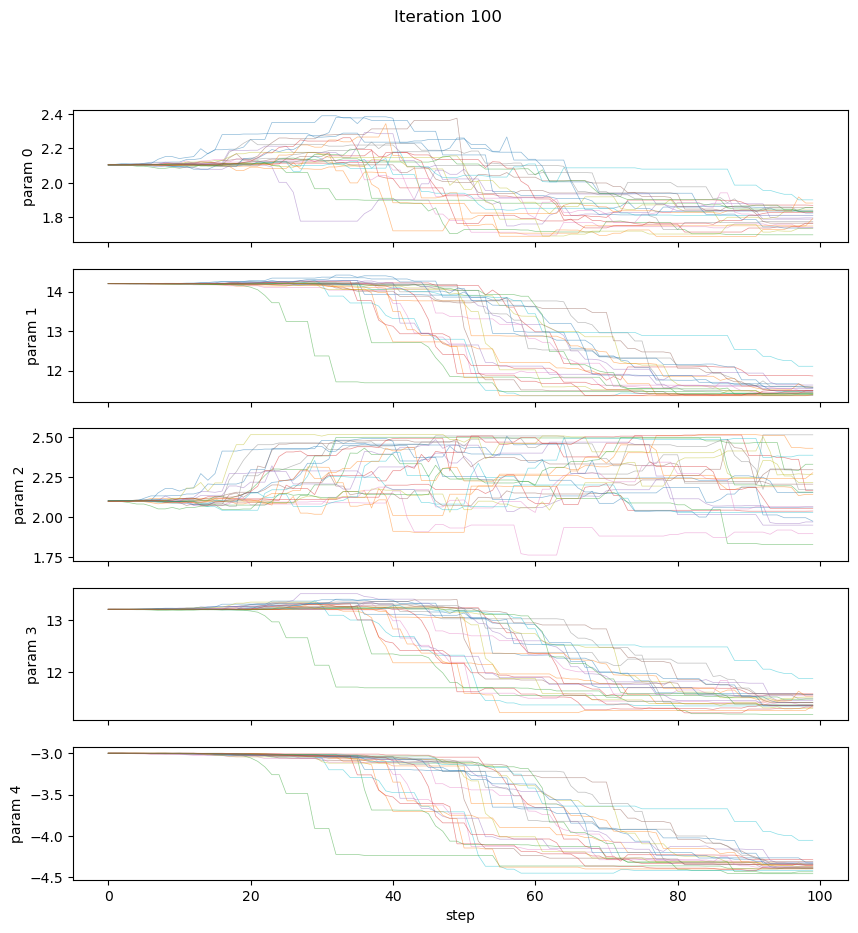

 44%|████▍     | 17529/40000 [15:44:30<20:10:48,  3.23s/it]
Process SpawnPoolWorker-12:
Process SpawnPoolWorker-9:
Process SpawnPoolWorker-8:
Process SpawnPoolWorker-7:
Process SpawnPoolWorker-10:
Process SpawnPoolWorker-6:
Process SpawnPoolWorker-2:
Process SpawnPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/thomasmc/anaconda3/envs/charisenv/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/thomasmc/anaconda3/envs/charisenv/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/thomasmc/anaconda3/envs/charisenv/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/thomasmc/anaconda3/envs/charisenv/lib/python3.9/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/home/thomasmc/anaconda3/envs/charisenv/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter

emcee: Exception while calling your likelihood function:
  params: emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:  params:
  params:
    params: [ 1.86230823 13.71929945  1.99674085 14.20707534 -5.9192811 ]
[ 1.85842125 12.87773581  1.93274936 12.55704763 -5.86028195][ 2.02704717 13.65903004  2.12735831 13.44433917 -5.87762186]  args:
 
  args:  args:[ 2.48168441 15.39440955  2.83806017 16.15953651 -5.9176406 ]  
  args: (<pyMuellerMat.MuellerMat.SystemMuellerMatrix object at 0x7f46d824fd90>, array([ 3.07646946e+02,  2.52219236e+05, -5.80119240e+03, ...,
        8.96162685e+05, -5.93490290e+04,  8.76269641e+05]), array([ 681.81343312,  681.81343312,  643.69286979, ..., 1302.32161375,
       1214.90522101, 1214.90522101]), [{'hwp': {'theta': 0.0, 'wavelength': 1159.5614}, 'image_rotator': {'theta': 97.8916, 'wavelength': 1159.5614}, 'altitude_rot': {'pa': 66.7789911

In [ ]:
ndim = 4  # Number of parameters to fit
# Detect computing resources
pool_processes = max(1, 12) # Leaving one free
nwalkers = max(2 * ndim, pool_processes * 2)
if nwalkers % pool_processes != 0:
    nwalkers += pool_processes - (nwalkers % pool_processes)

sampler, p_keys = run_mcmc(p0_dict, system_mm, interleaved_values_all,configuration_list_all,prior_dict,bounds, errors=interleaved_stds_all,output_h5_file= output_h5,nwalkers=nwalkers, log_f=-3.0, pool_processes=pool_processes,process_model=process_model, process_errors=process_errors,process_dataset=process_dataset,nsteps=40000,plot=True, include_sums=False)

In [12]:
def plot_corner_flat(chain, param_names, step_range=(0, None), median_or_max="median", num_bins=100):
    flat_chain = chain[step_range[0]:step_range[1], :, :].reshape(-1, chain.shape[-1])
    converted_chain = flat_chain.copy()

    for i, name in enumerate(param_names):
        if ".phi" in name:
            converted_chain[:, i] = converted_chain[:, i] / (2 * np.pi)

    if median_or_max == "median":
        truths = np.median(converted_chain, axis=0)
    elif median_or_max == "max":
        truths = []
        for i in range(converted_chain.shape[1]):
            hist, bin_edges = np.histogram(converted_chain[:, i], bins=num_bins)
            max_index = np.argmax(hist)
            max_val = (bin_edges[max_index] + bin_edges[max_index + 1]) / 2
            truths.append(max_val)
        truths = np.array(truths)
    else:
        raise ValueError("median_or_max must be 'median' or 'max'")
 
    fig = corner.corner(
        converted_chain,
        labels = [name.replace("delta_theta", "offset").replace("image_rotator", "imr") for name in param_names],
        truths=truths,
        plot_datapoints=False, label_kwargs={"fontsize":3}   # disables individual scatter points
    )

    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12)
        ax.xaxis.label.set_size(20)
        ax.yaxis.label.set_size(20)
        ax.xaxis.labelpad = 40
        ax.yaxis.labelpad = 40

    plt.tick_params(axis='x', which='both', pad=5)
    plt.tick_params(axis='y', which='both', pad=5)
    return fig

def load_chain_and_labels(h5_filename, txt_filename, include_logf=False):
    base, ext = os.path.splitext(h5_filename)
    h5_copy = base + "_copy" + ext
    shutil.copy(h5_filename, h5_copy)

    with h5py.File(h5_copy, 'r') as f:
        chain = f['mcmc']['chain'][:]

    with open(txt_filename, 'r') as f:
        p0_dict = json.load(f)

    param_names = [f"{comp}.{param}" for comp, params in p0_dict.items() for param in params]
    if include_logf:
        param_names.append("log_f")

    return chain, param_names

(40000, 14, 7)


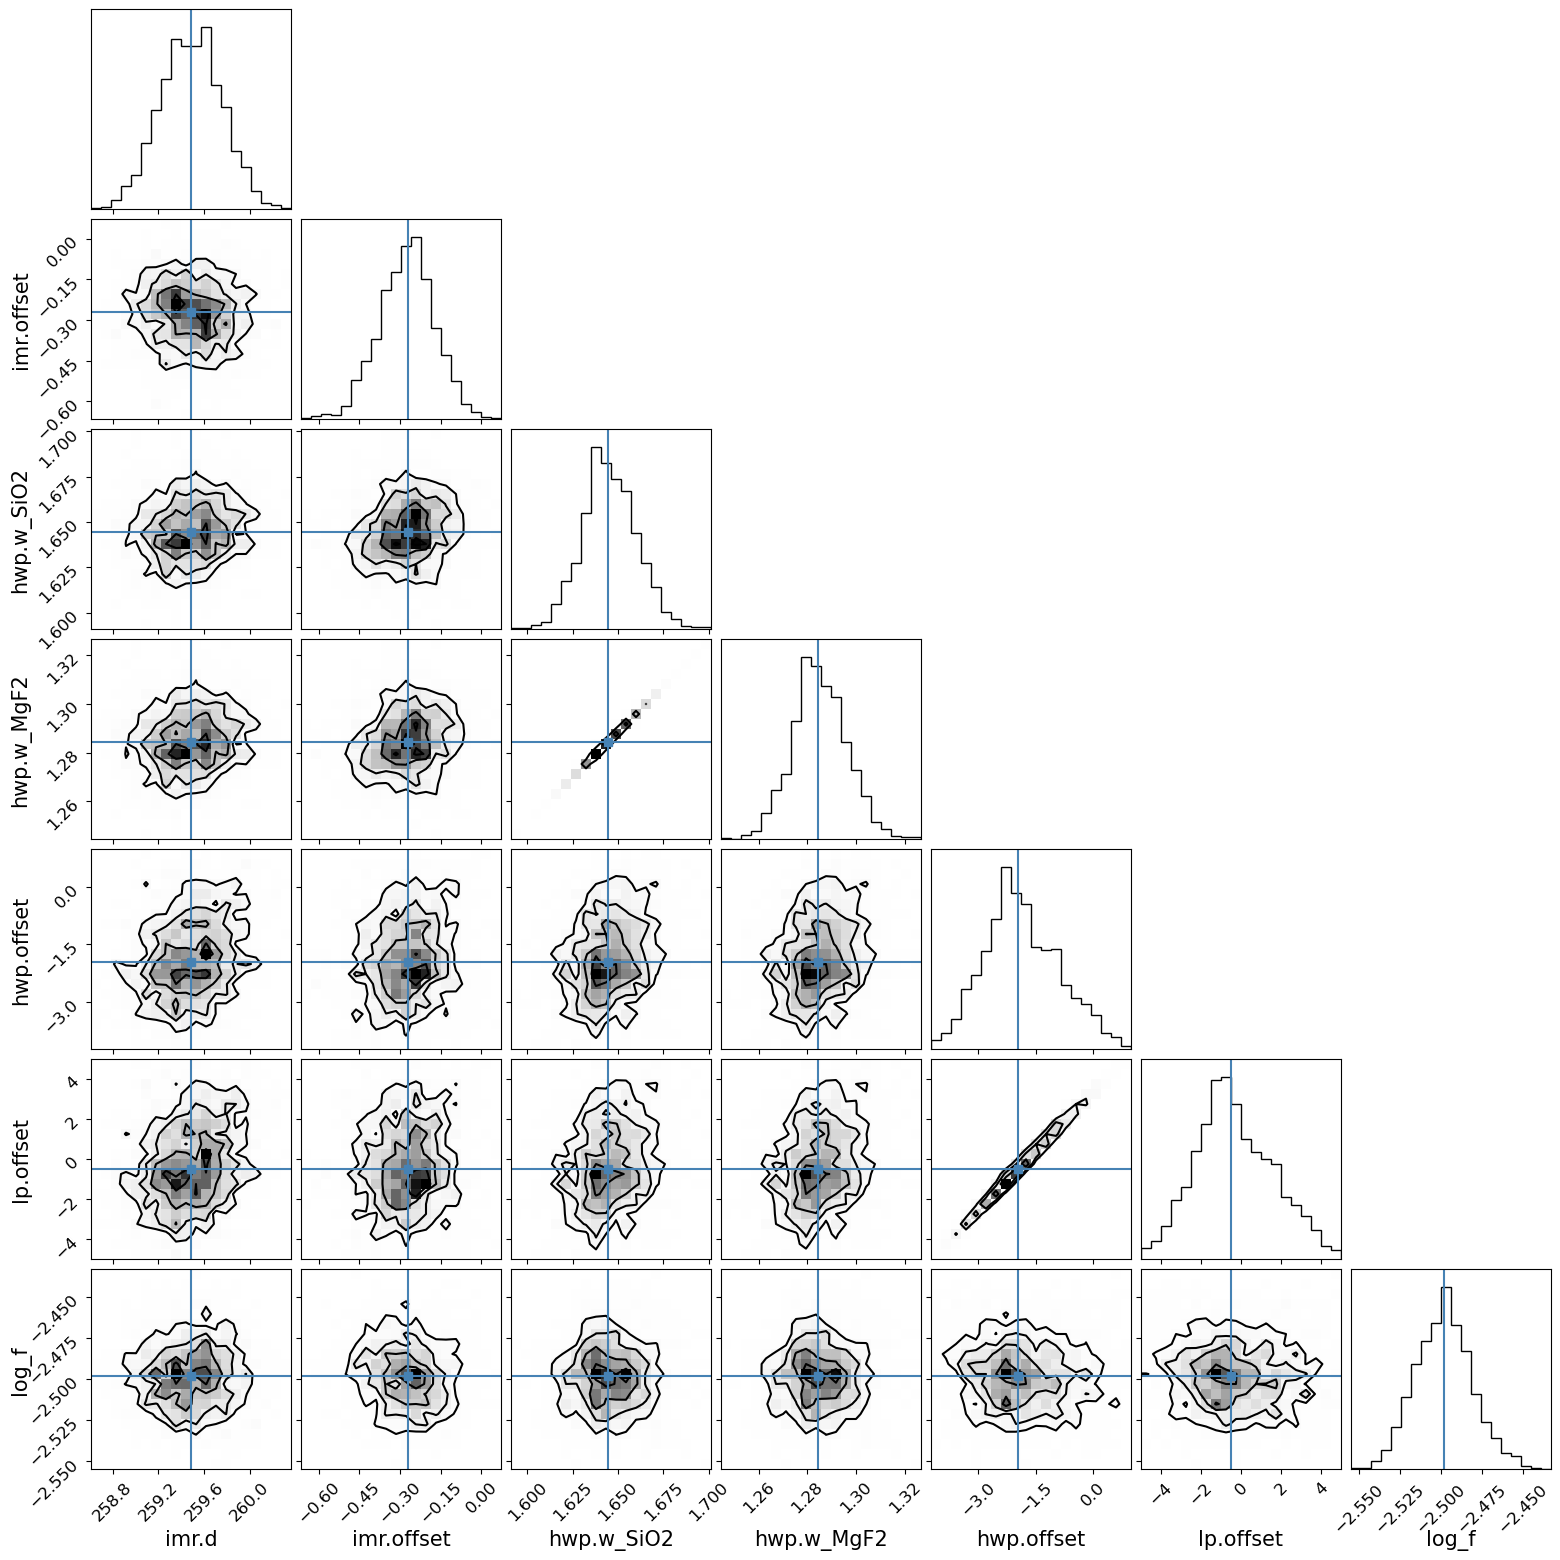

In [36]:
json_filepath = 'mcmc_p0_dict.json'
chain, names = load_chain_and_labels(output_h5, json_filepath, include_logf = True)
corner_plot_step_range = (15300,16000)
fig = plot_corner_flat(chain, names, step_range=corner_plot_step_range)
print(chain.shape)
for ax in fig.get_axes():
    if ax.xaxis.label:  # check label exists
        ax.xaxis.label.set_fontsize(15)  # your desired size
    if ax.yaxis.label:
        ax.yaxis.label.set_fontsize(15)


Looks like it converged nicely, but there is a clear degeneracy between the HWP offset and the LP offset. The degeneracy between the two HWP thicknesses seems reasonable.

Shape: (40000, 14, 7)
NaNs: False
Infs: False
Means: [104.45424905  -0.11170809   0.662411     0.51734372  -0.8034516
  -0.2433052 ]
Stds : [127.26602715   0.15240803   0.8071315    0.6303663    1.17201568
   1.30294641]


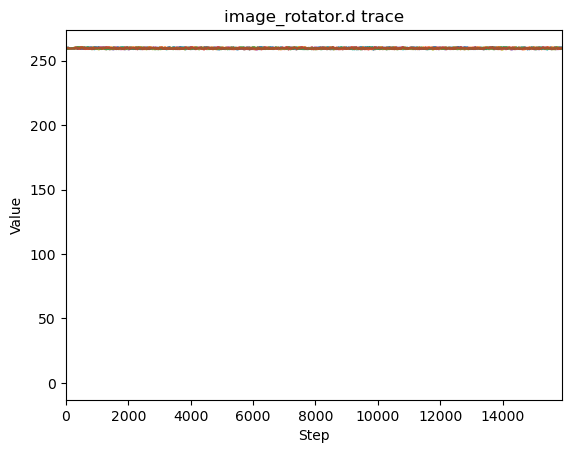

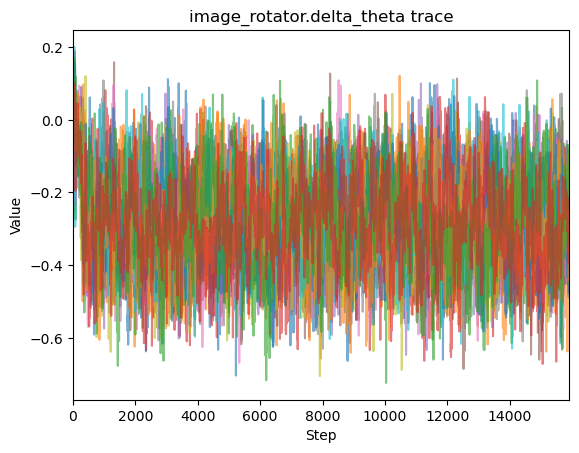

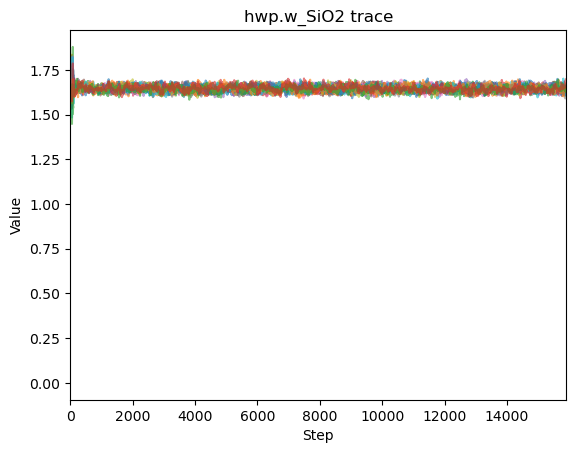

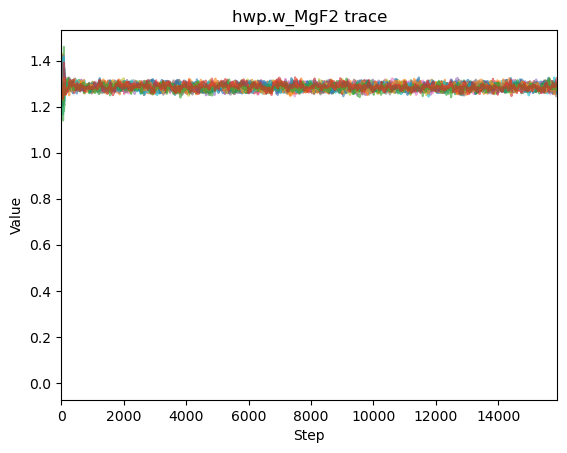

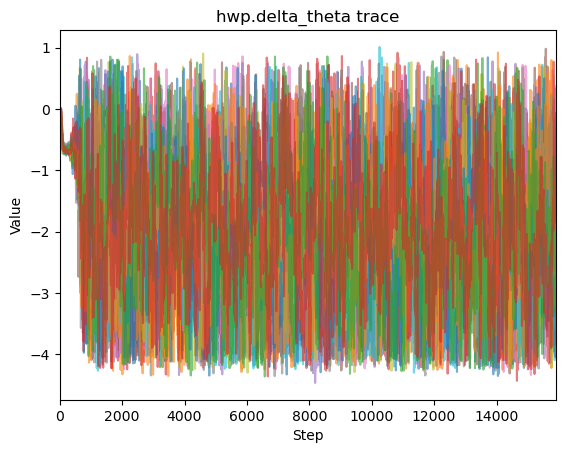

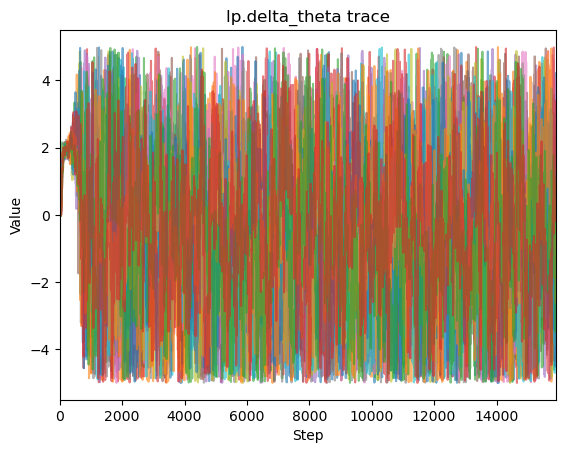

In [35]:
print("Shape:", chain.shape)
print("NaNs:", np.isnan(chain).any())
print("Infs:", np.isinf(chain).any())

means = np.mean(chain[:, :, :-1], axis=(0, 1))
stds = np.std(chain[:, :, :-1], axis=(0, 1))
print("Means:", means)
print("Stds :", stds)
for i in range(6):  # skip log(f)
    plt.figure()
    for w in range(14):
        plt.plot(chain[:, w, i], alpha=0.6)
        plt.xlim(0,15900)
    plt.title(f"{names[i]} trace")
    plt.xlabel("Step")
    plt.ylabel("Value")
    plt.show()

In [71]:
inst.summarize_median_posterior(output_h5,p0_dict,step_range=(8000,16000))


Posterior Medians and 1 sigma Credible Intervals:
image_rotator,d: 259.50747 (+0.25697/-0.25973)
image_rotator,delta_theta: -0.27842 (+0.10450/-0.10535)
hwp,w_SiO2: 1.64535 (+0.01395/-0.01380)
hwp,w_MgF2: 1.28501 (+0.01035/-0.01020)
hwp,delta_theta: -2.09738 (+1.04303/-1.01470)
lp,delta_theta: -0.79060 (+2.06934/-2.02202)


{'d': {'median': 259.50746657233975,
  '-1sigma': 0.2597310004093174,
  '+1sigma': 0.25696890428105235},
 'delta_theta': {'median': -0.7906034211926034,
  '-1sigma': 2.022023506822247,
  '+1sigma': 2.0693404855931012},
 'w_SiO2': {'median': 1.6453512171409417,
  '-1sigma': 0.013795243542661373,
  '+1sigma': 0.013945078977712244},
 'w_MgF2': {'median': 1.2850131158813587,
  '-1sigma': 0.010196693674887403,
  '+1sigma': 0.010346585381108664}}

There seem to be large errors on the hwp and lp offsets. Whatever is causing this degeneracy will require more investigation.